# Eindopdracht 1: Vector Space Models & Principle Component Analysis

Naam: Sietse Neve
Studentnummer: 1810364

## Deel I: Vector Space Models

### 1.

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

### 2.

In [2]:
df = pd.read_csv(
    'capitals.txt',
    sep=r'\s+',          
    header=None,
    names=['city1', 'country1', 'city2', 'country2'],
    engine='python',
)
df.head()


,city1,country1,city2,country2
0,Athens,Greece,Baghdad,Iraq
1,Athens,Greece,Bangkok,Thailand
2,Athens,Greece,Beijing,China
3,Athens,Greece,Berlin,Germany
4,Athens,Greece,Bern,Switzerland


### 3.

In [3]:
with open('word_embeddings_subset.p', 'rb') as f:
    embeddings = pickle.load(f)

print("Eerste paar rijen uit capitals.txt:")
print(df.head(), "\n")

num_embeddings = len(embeddings)
sample_word = list(embeddings.keys())[0]
embedding_dim = len(embeddings[sample_word])

print(f"Aantal embeddings: {num_embeddings}")
print(f"Voorbeeldwoord: {sample_word}")
print(f"Dimensie van embedding: {embedding_dim}")

assert num_embeddings == 243, "Aantal embeddings klopt niet (verwacht: 243)"
assert embedding_dim == 300, "Dimensie van embedding klopt niet (verwacht: 300)"
print("\n Embeddings hebben de verwachte vorm!")


Eerste paar rijen uit capitals.txt:
    city1 country1    city2     country2
0  Athens   Greece  Baghdad         Iraq
1  Athens   Greece  Bangkok     Thailand
2  Athens   Greece  Beijing        China
3  Athens   Greece   Berlin      Germany
4  Athens   Greece     Bern  Switzerland 

Aantal embeddings: 243
Voorbeeldwoord: country
Dimensie van embedding: 300

 Embeddings hebben de verwachte vorm!


### 4.

In [4]:

def cosine_similarity(a: np.ndarray, b: np.ndarray) -> float:
    """
    Bereken de cosine similarity tussen twee word vectors.
    
    Parameters:
    a (np.ndarray): vector 1
    b (np.ndarray): vector 2
    
    Returns:
    float: cosine similarity waarde tussen -1 en 1
    """
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    
    if norm_a == 0 or norm_b == 0:
        raise ValueError("Een van de vectors heeft norm 0.")
    
    return dot_product / (norm_a * norm_b)


In [5]:
vec1 = np.array([1, 2, 3])
vec2 = np.array([1, 2, 3])
vec3 = np.array([-1, -2, -3])

print("vec1 vs vec2:", cosine_similarity(vec1, vec2))  # ~1.0 (identiek)
print("vec1 vs vec3:", cosine_similarity(vec1, vec3))  # ~-1.0 (tegengesteld)


vec1 vs vec2: 1.0
vec1 vs vec3: -1.0


### 5.

In [6]:
def euclidean_distance(a: np.ndarray, b: np.ndarray) -> float:
    """
    Bereken de Euclidean distance tussen twee word vectors.
    
    Parameters:
    a (np.ndarray): vector 1
    b (np.ndarray): vector 2
    
    Returns:
    float: Euclidean distance (>= 0)
    """
    if a.shape != b.shape:
        raise ValueError("De vectoren hebben niet dezelfde dimensie.")
    
    return np.linalg.norm(a - b)


In [7]:
vec1 = np.array([1, 2, 3])
vec2 = np.array([1, 2, 3])
vec3 = np.array([4, 5, 6])

print("vec1 vs vec2:", euclidean_distance(vec1, vec2))  # 0.0 (identiek)
print("vec1 vs vec3:", euclidean_distance(vec1, vec3))  # > 0 (verschillend)


vec1 vs vec2: 0.0
vec1 vs vec3: 5.196152422706632


### 6.

In [8]:
vec_king = embeddings['king']
vec_queen = embeddings['queen']

cos_sim = cosine_similarity(vec_king, vec_queen)

euc_dist = euclidean_distance(vec_king, vec_queen)

print(f"Cosine similarity (king, queen): {cos_sim:.7f}")
print(f"Euclidean distance (king, queen): {euc_dist:.7f}")


Cosine similarity (king, queen): 0.6510956
Euclidean distance (king, queen): 2.4796925


### 7.

In [9]:
def find_country_for_city(city1: str, country1: str, city2: str, embeddings: dict):
    """
    Vind het meest waarschijnlijke land bij city2 op basis van een analoge relatie.

    city1: hoofdstad van country1
    country1: land van city1
    city2: hoofdstad van een ander land
    embeddings: dictionary {woord: vector}

    Returns:
    tuple: (gevonden_land, similarity_score)
    """
    for word in [city1, country1, city2]:
        if word not in embeddings:
            raise ValueError(f"'{word}' niet gevonden in embeddings.")

    target_vector = embeddings[city2] - embeddings[city1] + embeddings[country1]

    best_word = None
    best_similarity = -float('inf')

    for word, vector in embeddings.items():
        if word in [city1, country1, city2]:
            continue  # inputwoorden overslaan
        sim = cosine_similarity(target_vector, vector)
        if sim > best_similarity:
            best_similarity = sim
            best_word = word

    return best_word, best_similarity


### 8.

In [10]:
result = find_country_for_city("Athens", "Greece", "Cairo", embeddings)
print(f"Resultaat: {result}")

expected_country = "Egypt"
expected_similarity = 0.7626822

assert result[0] == expected_country, f"Fout: verwacht {expected_country}, kreeg {result[0]}"
assert abs(result[1] - expected_similarity) < 1e-7, (
    f"Fout: verwacht {expected_similarity}, kreeg {result[1]}"
)

print("\n Test geslaagd!")


Resultaat: ('Egypt', np.float32(0.7626822))

 Test geslaagd!


### 9.

In [11]:
def find_country_for_city_candidates(city1: str, country1: str, city2: str, embeddings: dict, candidates: set):
    """
    Bepaal het meest waarschijnlijke land voor city2 op basis van een analoge relatie:
    city1 is hoofdstad van country1, city2 is hoofdstad van ? (te bepalen).

    Parameters
    ----------
    city1 : str
        Hoofdstad van country1.
    country1 : str
        Land waarvan city1 de hoofdstad is.
    city2 : str
        Hoofdstad van een ander land waarvoor het bijbehorende land gezocht wordt.
    embeddings : dict
        Dictionary met woorden als keys en hun embedding (numpy array) als values.
    candidates : set
        Set van kandidaatlanden waaruit gekozen wordt.

    Returns
    -------
    tuple
        (gevonden_land, similarity_score) waarbij gevonden_land het land is met de hoogste
        cosine similarity ten opzichte van de berekende target vector.
    """
    for word in [city1, country1, city2]:
        if word not in embeddings:
            raise ValueError(f"'{word}' niet gevonden in embeddings.")

    target_vector = embeddings[city2] - embeddings[city1] + embeddings[country1]

    best_word = None
    best_similarity = -float('inf')

    for word in candidates:
        if word in (city1, country1, city2):
            continue
        sim = cosine_similarity(target_vector, embeddings[word])
        if sim > best_similarity:
            best_similarity = sim
            best_word = word

    return best_word, best_similarity

In [12]:
country_candidates = set(df['country1']).union(set(df['country2']))
country_candidates = {c for c in country_candidates if c in embeddings}

used = 0
skipped = 0
correct = 0
predictions = []

for _, row in df.iterrows():
    city1, country1, city2, gold_country = row['city1'], row['country1'], row['city2'], row['country2']

    pred_country, sim = find_country_for_city_candidates(city1, country1, city2, embeddings, country_candidates)
    predictions.append((gold_country, pred_country, sim, (city1, country1, city2)))
    correct += int(pred_country == gold_country)
    used += 1

accuracy = correct / used if used else 0.0
print(f"Accuracy: {accuracy:.4f}  (verwacht ~0.92)")

Accuracy: 0.9251  (verwacht ~0.92)


## Deel 2

In [24]:
def pca_reduce(X: np.ndarray, n_components: int = 2) -> np.ndarray:
    """
    PCA-reductie van word vectors.
    
    Parameters:
    X (np.ndarray): matrix van vorm (m, n) met m = aantal woorden, n = dimensies
    n_components (int): aantal gewenste dimensies
    
    Returns:
    np.ndarray: getransformeerde data met vorm (m, n_components)
    """
    # 1. Data centreren (gemiddelde per kolom)
    X_mean = np.mean(X, axis=0)
    X_centered = X - X_mean
    
    # 2. Covariantiematrix berekenen
    covariance_matrix = np.cov(X_centered, rowvar=False)
    
    # 3. Eigenwaarden en eigenvectoren berekenen
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    
    # 4. Sorteer eigenvectoren op aflopende eigenwaarde
    sorted_indices = np.argsort(eigenvalues)[::-1]
    top_indices = sorted_indices[:n_components]
    principal_components = eigenvectors[:, top_indices]
    
    # 5. Projecteer data op de gekozen componenten
    X_reduced = np.dot(X_centered, principal_components)
    
    return X_reduced

In [25]:
def compute_pca(X: np.ndarray, n_components: int = 2) -> np.ndarray:
    """
    Voer PCA uit op word vectors.

    Parameters
    ----------
    X : np.ndarray
        Vorm (m, n): m woordvectoren, n dimensies per vector.
    n_components : int
        Aantal gewenste hoofdcomponenten (kolommen) in de output.

    Returns
    -------
    np.ndarray
        X_reduced met vorm (m, n_components).
    """
    X = np.asarray(X, dtype=float)
    if n_components <= 0 or n_components > X.shape[1]:
        raise ValueError("n_components moet tussen 1 en het aantal kolommen van X liggen.")

    # 1) Centreer data
    mean = np.mean(X, axis=0, keepdims=True)
    X_centered = X - mean

    # 2) Covariantiematrix (kolommen = variabelen)
    C = np.cov(X_centered, rowvar=False)

    # 3) Eigen-decompositie (symmetrische matrix -> eigh)
    eigvals, eigvecs = np.linalg.eigh(C)  # kolommen van eigvecs zijn eigenvectoren

    # 4) Sorteer op afnemende eigenvalue
    idx = np.argsort(eigvals)[::-1]
    eigvecs_sorted = eigvecs[:, idx]

    # 5) Neem de eerste n eigenvectoren
    W = eigvecs_sorted[:, :n_components]  # vorm (n, n_components)

    # 6) Projecteer gecentreerde data op deze componenten
    X_reduced = X_centered @ W            # vorm (m, n_components)

    return X_reduced


In [26]:
np.random.seed(1)
X = np.random.rand(3, 10)
X_reduced = compute_pca(X, n_components=2)
print("De originele matrix is " + str(X.shape) + ", en na PCA:")
print(X_reduced)

De originele matrix is (3, 10), en na PCA:
[[ 0.43437323 -0.49820384]
 [ 0.42077249  0.50351448]
 [-0.85514571 -0.00531064]]


In [27]:
def get_embeddings_matrix(embeddings: dict, words: list) -> np.ndarray:
    """
    Haal embeddings op voor een lijst van woorden.

    Parameters
    ----------
    embeddings : dict
        Dictionary met woorden als keys en numpy arrays als values.
    words : list
        Lijst van woorden waarvan de embeddings opgehaald worden.

    Returns
    -------
    np.ndarray
        Matrix met vorm (len(words), embedding_dim), elke rij is de embedding van één woord.
    """
    X = []
    for w in words:
        if w not in embeddings:
            raise ValueError(f"Woord '{w}' niet gevonden in embeddings.")
        X.append(embeddings[w])
    return np.vstack(X)


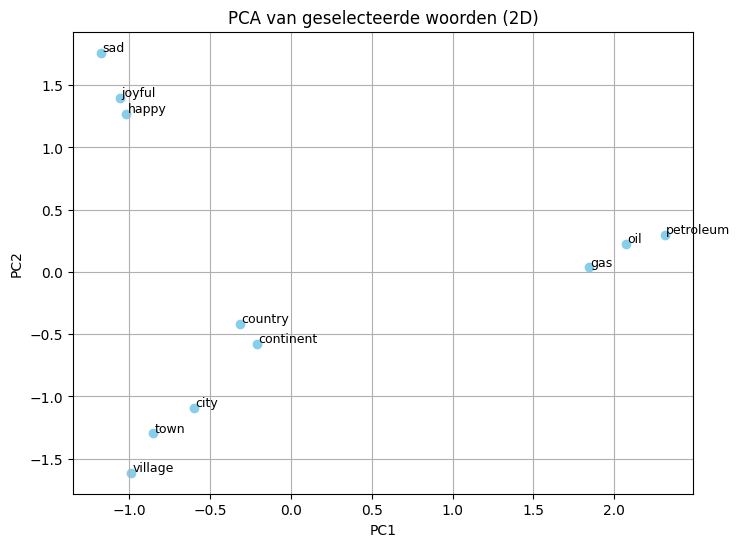

In [28]:
# Woordenlijst
words = ['oil', 'gas', 'happy', 'sad', 'city', 'town', 'village',
         'country', 'continent', 'petroleum', 'joyful']

X = get_embeddings_matrix(embeddings, words)

X_reduced = pca_reduce(X, n_components=2)

plt.figure(figsize=(8, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], color='skyblue')

for i, word in enumerate(words):
    plt.text(X_reduced[i, 0] + 0.01, X_reduced[i, 1] + 0.01, word, fontsize=9)

plt.title("PCA van geselecteerde woorden (2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


In de PCA-visualisatie zijn duidelijke semantische clusters te onderscheiden. De energiegerelateerde termen (oil, gas, petroleum) bevinden zich dicht bij elkaar aan de rechterzijde van de plot. De emotiegerelateerde woorden (happy, joyful, sad) vormen een groep in het bovenste linkerkwadrant, waarbij sad enigszins gescheiden ligt maar nog wel binnen dezelfde betekenisruimte. Sad is dan ook een andere emotie dan joyful en happy. De geografische termen (city, town, village, country, continent) zijn samengebracht in het onderste en centrale deel van de visualisatie. Er zijn zelfs subgroepen te zien, waarbij onderscheid wordt gemaakt tussen grote en kleine regio's. Deze groepering bevestigt dat de PCA-projectie de onderliggende semantische structuur van de woordvectoren behoudt, waarbij betekenisvolle overeenkomsten resulteren in ruimtelijke nabijheid.